# Introduction

* ARIMA: We use the ARIMA (AutoRegressive Integrated Moving Average) model, which is a classic time series forecasting method. It captures the linear relationships between data points and accounts for trends and seasonality.
* SARIMAX: This is an extension of the ARIMA model that includes exogenous variables. It's useful when external factors influence the time series, such as holidays or promotions.
* Auto ARIMA: To simplify the model selection process, we use the auto_arima function, which automatically identifies the best ARIMA parameters based on the data.

**NOTE: we will work with store number 4.**

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, arima_preds, label='Forecast', color='red')
plt.title('ETS Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, arima_preds, label='Forecast', color='red')
plt.title('ETS Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()# Import Libraries

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [12]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.3 MB/s eta 0:00:0000:01


In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


# Load and Preprocess Data

In [272]:
# Load the data
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')


In [363]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [364]:
# Create a DataFrame containing 'Store', 'Promo' and 'StateHoliday' columns
external_factors = train[['Store','Promo', 'StateHoliday']]

# Convert 'StateHoliday' to dummy variables (0 for non-holiday, 1 otherwise)
external_factors = pd.get_dummies(external_factors, columns=['StateHoliday'], drop_first=True)

# Check the first few rows of the external_factors DataFrame
external_factors.head()

,Store,Promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,
2015-07-31,1,1,True,False,False,False
2015-07-31,2,1,True,False,False,False
2015-07-31,3,1,True,False,False,False
2015-07-31,4,1,True,False,False,False
2015-07-31,5,1,True,False,False,False


In [273]:
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Set Date as the index
train.set_index('Date', inplace=True)

# Filter data for Store 4
store_4_data = train[train['Store'] == 4]

# Sort data by date
store_4_data.sort_index(inplace=True)

In [365]:
# Get the external factors for Store 4
external_factors_4 = external_factors[external_factors['Store'] == 4]
external_factors_4.sort_index(inplace=True)

In [371]:
# Convert 'Promo' and 'StateHoliday' columns to integer type
external_factors_4['Promo'] = external_factors_4['Promo'].astype(int)
external_factors_4['StateHoliday_0'] = external_factors_4['StateHoliday_0'].astype(int)
external_factors_4['StateHoliday_a'] = external_factors_4['StateHoliday_a'].astype(int)
external_factors_4['StateHoliday_b'] = external_factors_4['StateHoliday_b'].astype(int)
external_factors_4['StateHoliday_c'] = external_factors_4['StateHoliday_c'].astype(int)

In [374]:
# Ensure the index of external_factors_4 is also reset
external_factors_4.reset_index(drop=True, inplace=True)

In [375]:
external_factors_4.head()

,Promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0,0,1,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [274]:
train_sales=store_4_data['Sales']

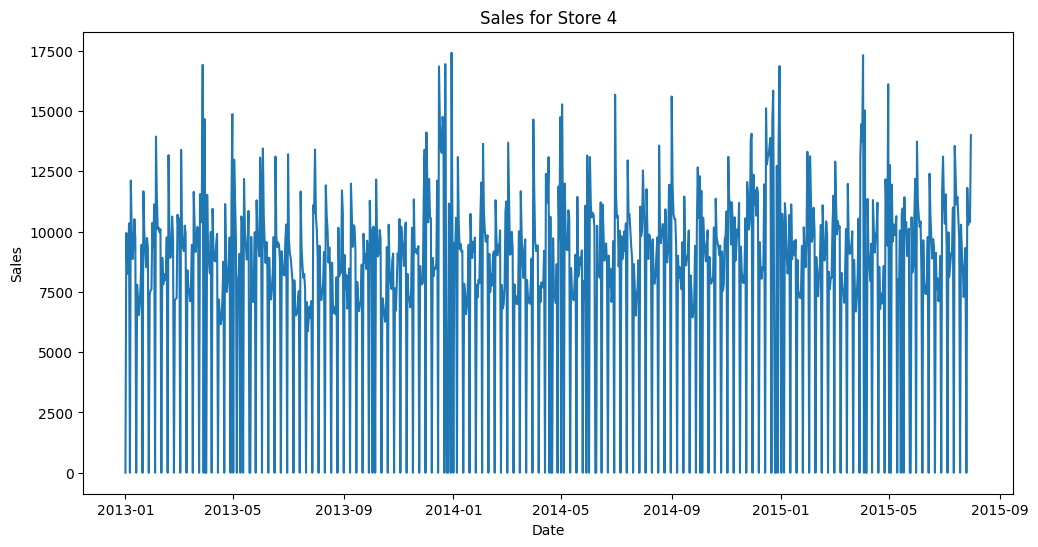

In [275]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(train_sales)
plt.title('Sales for Store 4')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


# Train-Test Split

In [276]:
train_size = int(len(store_4_data) * 0.8)
train_data = store_4_data[:train_size].copy(deep=True)
test_data = store_4_data[train_size:].copy(deep=True)

# Define RMSPE function with handling for zero values

In [277]:
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

# Check stationarity

## Define kpss_test function

In [278]:
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    # Print test results
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The Data is not stationary")
    else:
        print("The Data is stationary")

## Define adf_test function

In [279]:
def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")
    
    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    if result[1] <= threshold:
        print("Conclusion:====>") 
        print("Reject the null hypothesis") 
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis") 
        print("Data is non-stationary")

In [280]:
adf_test(train_data[["Sales"]])

ADF Statistic: -4.399723499043098
p-value: 0.00029716725346155565
Critical Values:
	1%: -3.439314999916068
	5%: -2.8654965012008677
	10%: -2.5688768817372867
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [281]:
kpss_test(train_data[["Sales"]])

KPSS Statistic: 0.5901183873309634
p-value: 0.023534692060821504
Lags Used: 6
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The Data is not stationary


# Arima Model

In [340]:
ARIMA_model = ARIMA(train_data[["Sales"]], order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

In [341]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)

In [342]:
# Replace when not open with 0
arima_preds[test_data["Open"] == 0] = 0

In [343]:
print(f'RMSPE for Arima on test:{rmspe(arima_preds,test_data[["Sales"]])}')

RMSPE for Arima on test:0.334830893044142


## Another try with Arima

In [354]:
ARIMA_model = ARIMA(train_data[["Sales"]], order=(2, 2, 2))
ARIMA_model_fit = ARIMA_model.fit()
#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)
arima_preds[test_data["Open"] == 0] = 0
print(f'RMSPE for Arima on test:{rmspe(arima_preds,test_data[["Sales"]])}')

RMSPE for Arima on test:0.27192682893060127


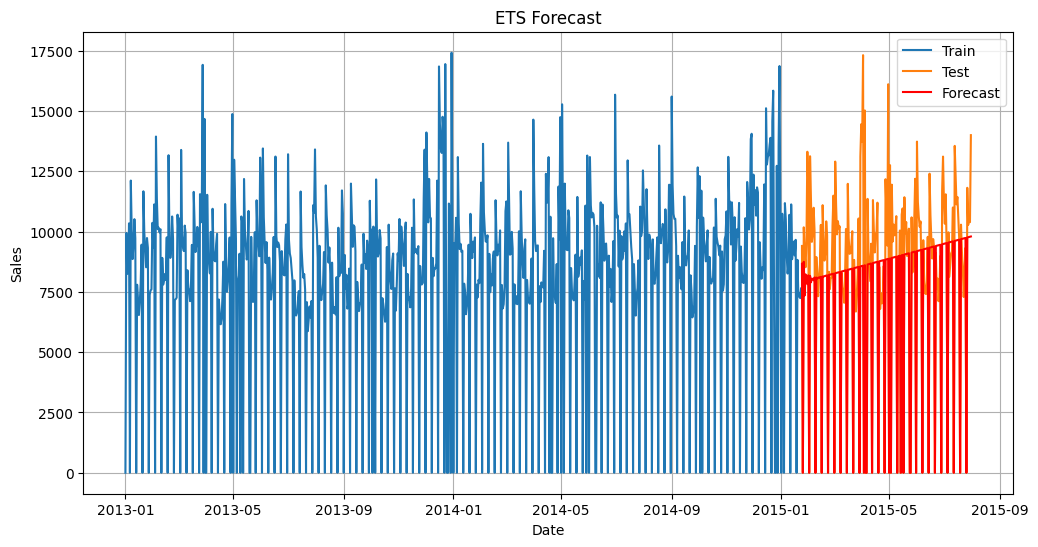

In [355]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, arima_preds, label='Forecast', color='red')
plt.title('ETS Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# SARIMAX Model

**we will try without external values**

In [306]:
SARIMAX_model = SARIMAX(train_data[["Sales"]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
SARIMAX_model_fit = SARIMAX_model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24946D+00    |proj g|=  6.70882D-02


 This problem is unconstrained.



At iterate    5    f=  9.18677D+00    |proj g|=  6.40261D-03

At iterate   10    f=  9.18202D+00    |proj g|=  9.92947D-04

At iterate   15    f=  9.18195D+00    |proj g|=  1.61844D-03

At iterate   20    f=  9.18191D+00    |proj g|=  1.63504D-04

At iterate   25    f=  9.18176D+00    |proj g|=  4.93103D-03

At iterate   30    f=  9.13092D+00    |proj g|=  2.24990D-01

At iterate   35    f=  9.04910D+00    |proj g|=  5.04171D-03

At iterate   40    f=  9.04756D+00    |proj g|=  5.33039D-03

At iterate   45    f=  9.04733D+00    |proj g|=  2.89092D-04

At iterate   50    f=  9.04732D+00    |proj g|=  8.00753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [307]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)

In [308]:
SARIMAX_preds[test_data["Open"] == 0] = 0

In [309]:
print(f'RMSPE for SARIMAX on test:{rmspe(SARIMAX_preds,test_data[["Sales"]])}')

RMSPE for SARIMAX on test:0.20014484362781815


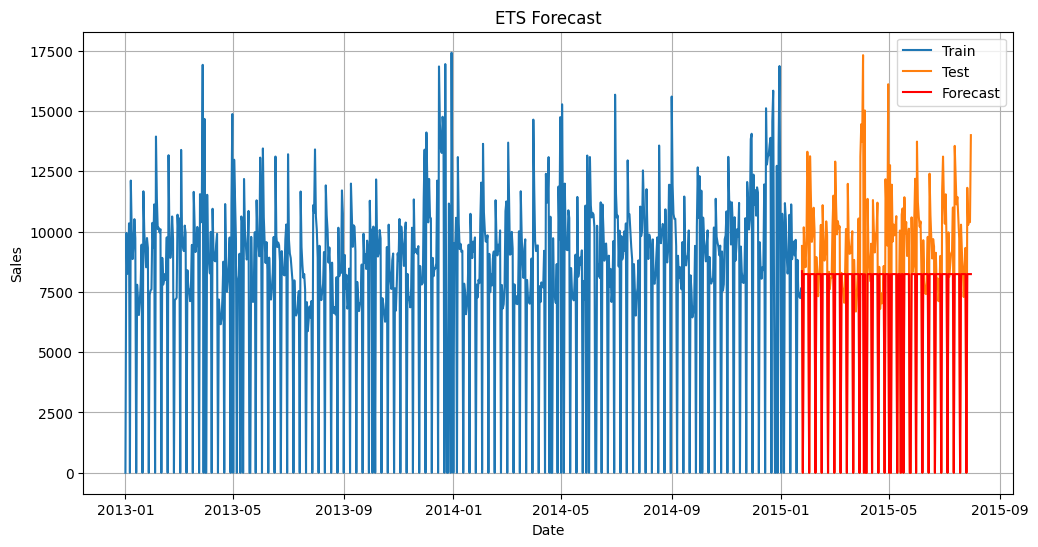

In [292]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, arima_preds, label='Forecast', color='red')
plt.title('ETS Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## **Now the time to try with external variables**

In [377]:
# Reset the index of train_data[["Sales"]]
endog_data = train_data[["Sales"]].reset_index(drop=True)

In [380]:
# Truncate or pad external_factors_4 to match the length of endog_data
external_factors_4 = external_factors_4.iloc[:len(endog_data)]

# Set the index of external_factors_4 to match endog_data's index
external_factors_4.index = endog_data.index

In [381]:
SARIMAX_ex_model = SARIMAX(endog_data, exog=external_factors_4, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
SARIMAX_ex_model_fit = SARIMAX_ex_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62356D+00    |proj g|=  7.41620D-02

At iterate    5    f=  8.57452D+00    |proj g|=  1.87883D-02

At iterate   10    f=  8.57087D+00    |proj g|=  5.56792D-03

At iterate   15    f=  8.56967D+00    |proj g|=  3.83513D-03

At iterate   20    f=  8.56769D+00    |proj g|=  8.18378D-03

At iterate   25    f=  8.53863D+00    |proj g|=  1.33954D-01

At iterate   30    f=  8.48724D+00    |proj g|=  6.49733D-03

At iterate   35    f=  8.48712D+00    |proj g|=  3.09642D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [384]:
start_index_ex = endog_data.index.min()
end_index_ex=endog_data.index.max()
SARIMAX_ex_preds = SARIMAX_ex_model_fit.predict(start=start_index_ex, end=end_index_ex,exog=external_factors_4)

In [387]:
# Calculate RMSPE for SARIMAX predictions
print(f'RMSPE for SARIMAX on test:{rmspe(SARIMAX_ex_preds,endog_data)}')

RMSPE for SARIMAX on test:0.18229804779132552


## **we can see that adding external variables improve the model.**

# Auto Arima

In [346]:
stepwise_model = auto_arima(train_data[["Sales"]],start_p=2, start_q=2,d=2, max_p=3, max_q=3,
                            seasonal=True, start_P =2, start_Q=2, D=2, max_Q=3, max_P=3, max_order=12, m=7,
                            trace=True,stationary=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=14144.612, Time=7.11 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14627.379, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14513.098, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14457.863, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=15835.868, Time=0.03 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=inf, Time=6.50 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(2,0,2)(3,0,2)[7] intercept   : AIC=inf, Time=13.83 sec
 ARIMA(2,0,2)(2,0,3)[7] intercept   : AIC=inf, Time=10.86 sec
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(2,0,2)(1,0,3)[7] intercept   : AIC=inf, Time=11.20 sec
 ARIMA(2,0,2)(3,0,1)[7] intercept   : AIC=inf, Time=10.29 sec
 ARIMA(2,0,2)(3,0,3)[7] intercept   : AIC=inf, Time=14.32 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(

In [350]:
length = len(test_data)

#Predictions
auto_arima_forecast,conf_int = stepwise_model.predict(n_periods=length,return_conf_int=True)

In [351]:
auto_arima_forecast[test_data["Open"] == 0] = 0

In [352]:
print(f'RMSPE for Auto Arima on test:{rmspe(auto_arima_forecast,test_data[["Sales"]])}')

RMSPE for Auto Arima on test:0.281405292191385


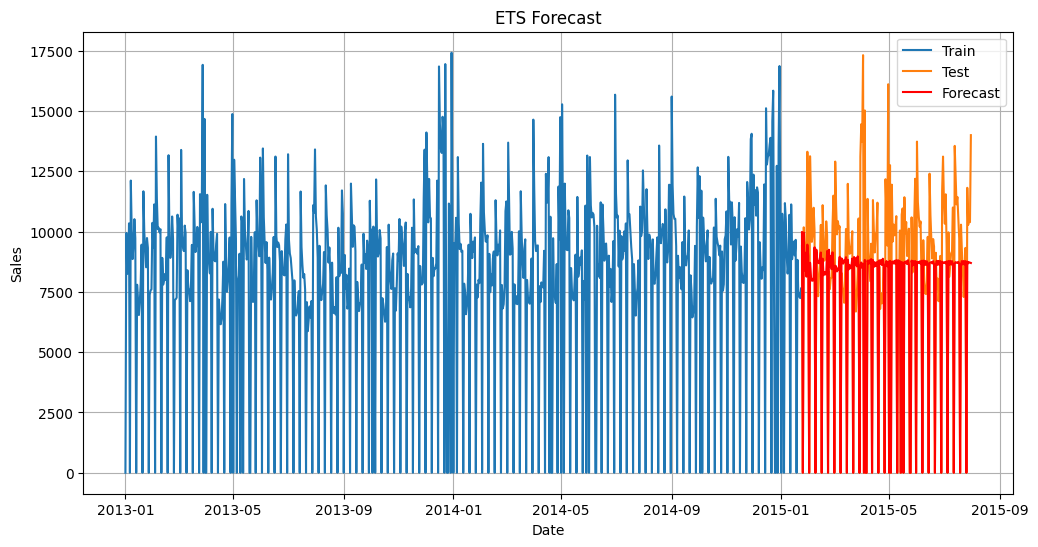

In [353]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, auto_arima_forecast, label='Forecast', color='red')
plt.title('ETS Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion 

| Model                          | RMSPE              |
|--------------------------------|--------------------|
| ARIMA(1,1,1)                   | 0.334830893044142  |
| ARIMA(2,2,2)                   | 0.27192682893060127|
| SARIMAX (without external values) | 0.20014484362781815|
| <span style="background-color:yellow">SARIMAX (with external values)</span> | <span style="background-color:yellow">0.18229804779132552</span> |
| Auto ARIMA((2,0,2)(2,0,2)[7])  | 0.281405292191385  |

